<a href="https://colab.research.google.com/github/Varada-Mantrawadi/ZeoTap_assigment/blob/main/ZeoTap_Assignment.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

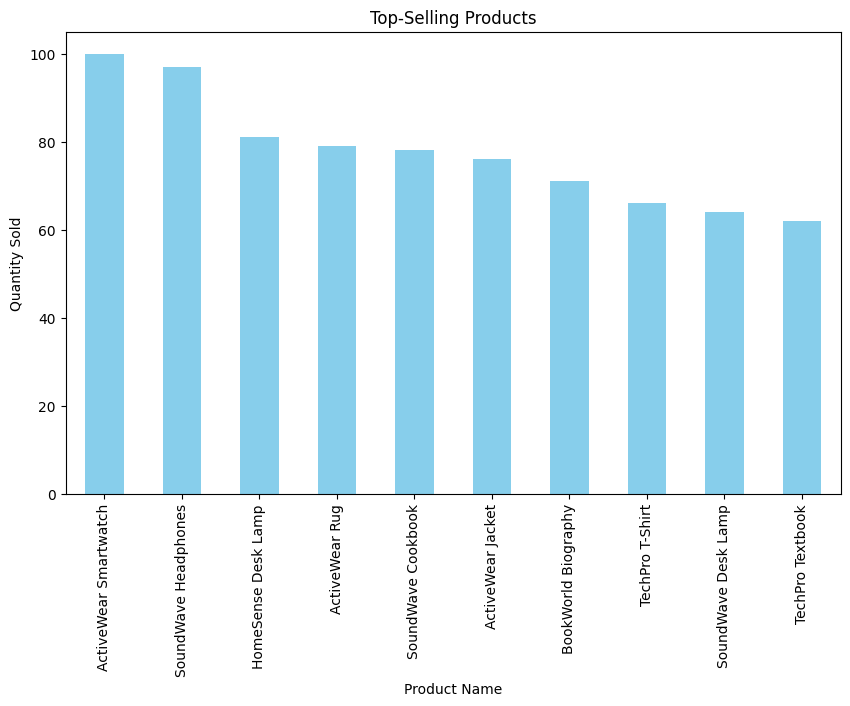

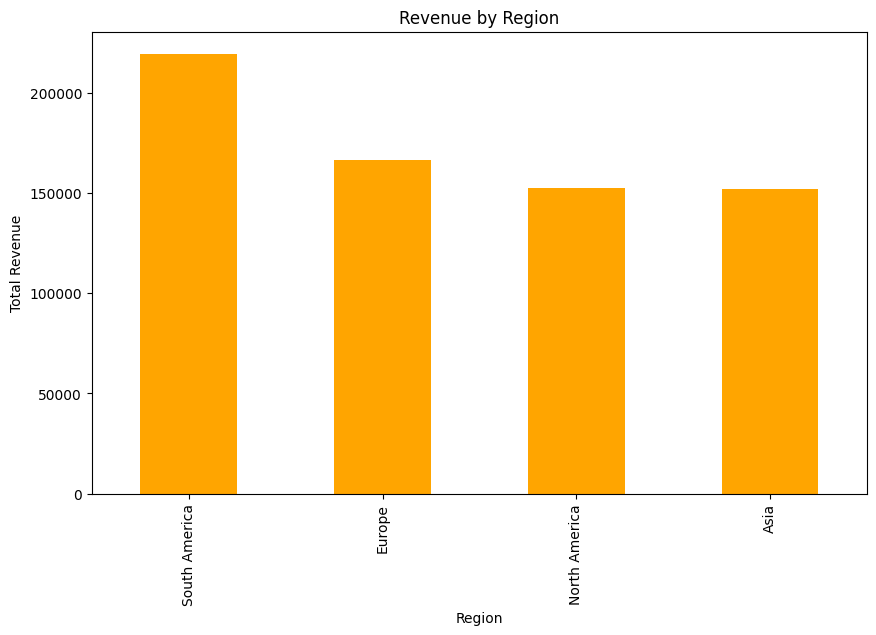

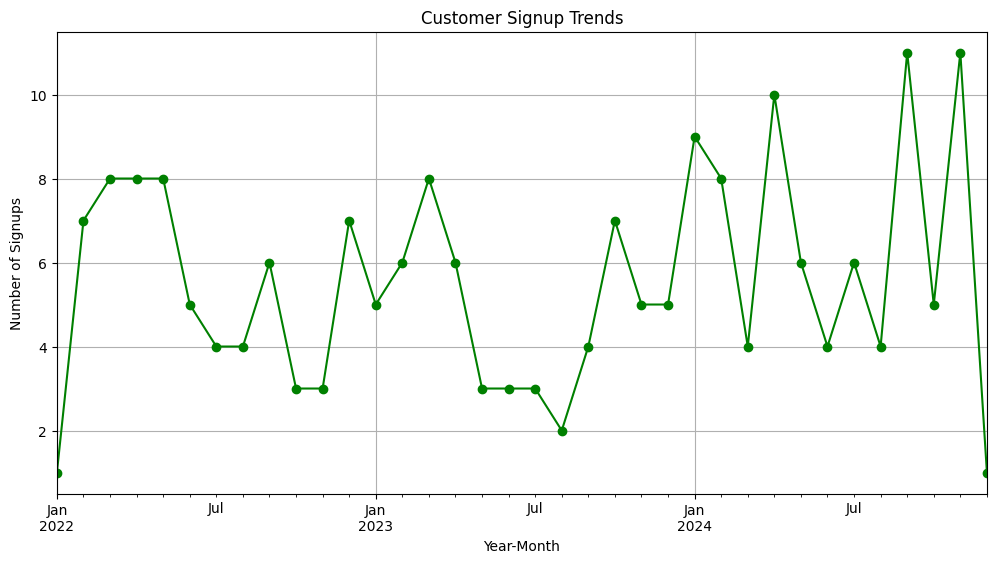

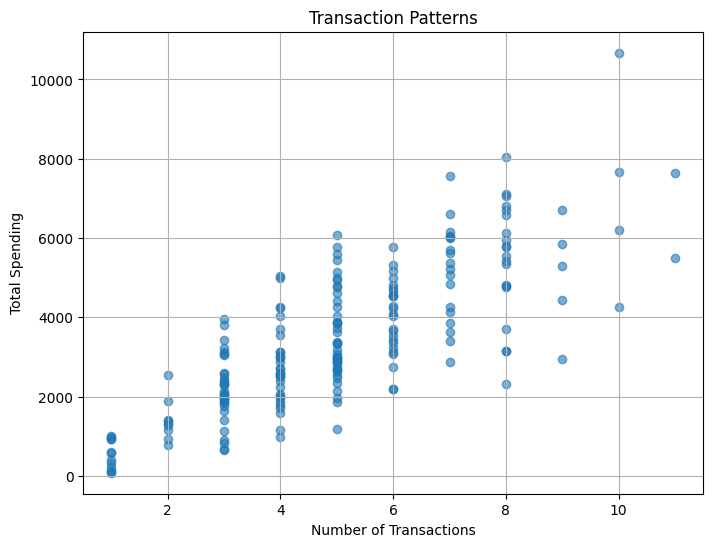

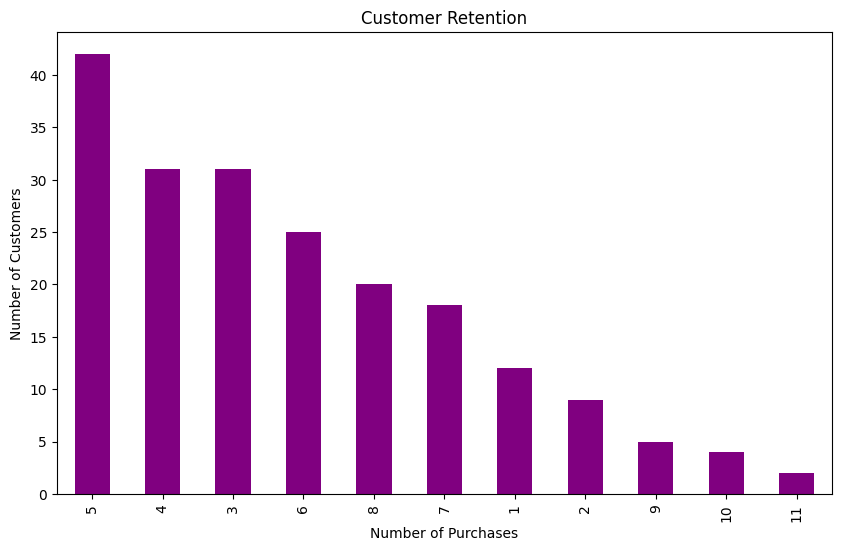

Davies-Bouldin Index: 0.8491558302577694


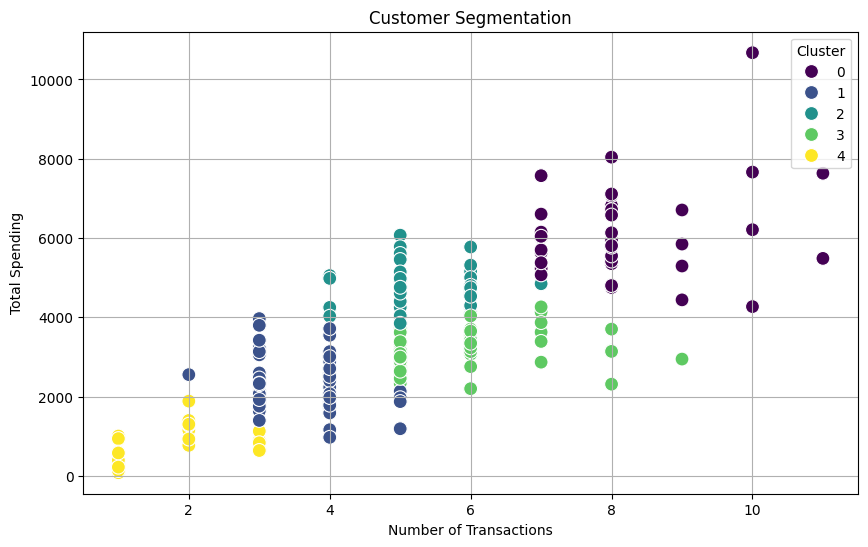

In [ ]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.metrics.pairwise import cosine_similarity
from sklearn.cluster import KMeans
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import davies_bouldin_score

# Load the datasets
customers = pd.read_csv("Customers.csv")
products = pd.read_csv("Products.csv")
transactions = pd.read_csv("Transactions.csv")

# --- Task 1: Exploratory Data Analysis (EDA) ---

# Merge datasets for comprehensive analysis
merged_data = transactions.merge(customers, on='CustomerID').merge(products, on='ProductID')

# Insight 1: Top-Selling Products
top_products = merged_data.groupby('ProductName')['Quantity'].sum().sort_values(ascending=False).head(10)
plt.figure(figsize=(10, 6))
top_products.plot(kind='bar', color='skyblue')
plt.title('Top-Selling Products')
plt.xlabel('Product Name')
plt.ylabel('Quantity Sold')
plt.show()

# Insight 2: Region-Wise Revenue
region_revenue = merged_data.groupby('Region')['TotalValue'].sum().sort_values(ascending=False)
plt.figure(figsize=(10, 6))
region_revenue.plot(kind='bar', color='orange')
plt.title('Revenue by Region')
plt.xlabel('Region')
plt.ylabel('Total Revenue')
plt.show()

# Insight 3: Signup Trends
customers['SignupDate'] = pd.to_datetime(customers['SignupDate'])
customers['SignupYearMonth'] = customers['SignupDate'].dt.to_period('M')
signup_trends = customers.groupby('SignupYearMonth').size()
plt.figure(figsize=(12, 6))
signup_trends.plot(kind='line', marker='o', color='green')
plt.title('Customer Signup Trends')
plt.xlabel('Year-Month')
plt.ylabel('Number of Signups')
plt.grid()
plt.show()

# Insight 4: Transaction Patterns
transaction_summary = merged_data.groupby('CustomerID')['TotalValue'].agg(['sum', 'count']).reset_index()
plt.figure(figsize=(8, 6))
plt.scatter(transaction_summary['count'], transaction_summary['sum'], alpha=0.6)
plt.title('Transaction Patterns')
plt.xlabel('Number of Transactions')
plt.ylabel('Total Spending')
plt.grid()
plt.show()

# Insight 5: Customer Retention
repeat_customers = merged_data.groupby('CustomerID').size().value_counts()
plt.figure(figsize=(10, 6))
repeat_customers.plot(kind='bar', color='purple')
plt.title('Customer Retention')
plt.xlabel('Number of Purchases')
plt.ylabel('Number of Customers')
plt.show()

# --- Task 2: Lookalike Model ---

# Prepare data for similarity calculation
customer_product_matrix = merged_data.pivot_table(index='CustomerID', columns='ProductID', values='Quantity', fill_value=0)
cos_sim = cosine_similarity(customer_product_matrix)
similarity_df = pd.DataFrame(cos_sim, index=customer_product_matrix.index, columns=customer_product_matrix.index)

# Generate Lookalikes for first 20 customers
lookalikes = {}
for customer_id in customer_product_matrix.index[:20]:
    similar_customers = similarity_df[customer_id].sort_values(ascending=False)[1:4]  # Top 3 excluding self
    lookalikes[customer_id] = list(similar_customers.items())

lookalikes_df = pd.DataFrame.from_dict(lookalikes, orient='index', columns=['Customer1', 'Customer2', 'Customer3'])
lookalikes_df.to_csv('Varada_Mantrawadi_Lookalike.csv', index_label='CustomerID')

# --- Task 3: Customer Segmentation ---

# Prepare data for clustering
features = transaction_summary[['sum', 'count']]
scaler = StandardScaler()
scaled_features = scaler.fit_transform(features)

# Perform KMeans clustering
kmeans = KMeans(n_clusters=5, random_state=42)
kmeans.fit(scaled_features)
transaction_summary['Cluster'] = kmeans.labels_

# Evaluate clustering
db_index = davies_bouldin_score(scaled_features, kmeans.labels_)
print(f"Davies-Bouldin Index: {db_index}")

# Visualize Clusters
plt.figure(figsize=(10, 6))
sns.scatterplot(x=transaction_summary['count'], y=transaction_summary['sum'], hue=transaction_summary['Cluster'], palette='viridis', s=100)
plt.title('Customer Segmentation')
plt.xlabel('Number of Transactions')
plt.ylabel('Total Spending')
plt.legend(title='Cluster')
plt.grid()
plt.show()

# Save clustering results
transaction_summary.to_csv('Varada_Mantrawadi_Clustering.csv', index=False)
